## Description of Project
Swahili is spoken by 100-150 million people across East Africa. In Tanzania, it is one of two national languages (the other is English) and it is the official language of instruction in all schools. News in Swahili is an important part of the media sphere in Tanzania.

News contributes to education, technology, and the economic growth of a country, and news in local languages plays an important cultural role in many Africa countries. In the modern age, African languages in news and other spheres are at risk of being lost as English becomes the dominant language in online spaces.

The objective of this hackathon is to develop a multi-class classification model to classify news content according to their specific categories specified.The model can be used by Swahili online news platforms to automatically group news according to their categories and help readers find the specific news they want to read. In addition, the model will contribute to a body of work ensuring that Swahili is represented in apps and other online products in the future.

## About
The dataset describes 6439 rows of news from different sources in Tanzania.These news are in 5 different news categories from national news to entertainment news.

The goal is to accurately classify each swahili news content into five specified categories below:

Kitaifa (National)
Kimataifa (International)
Biashara (Business)
Michezo (Sports)
Burudani (Entertainment)

### Import necessary libraries

In [26]:
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight


# Load the training data
train_data = pd.read_csv("C:\\Users\\NdoMuteweri\\Desktop\\Machine Learning\\projects\\Swahili News Classification\\Train.csv")


## Data Exploration

       id                                            content  category
0     SW0   SERIKALI imesema haitakuwa tayari kuona amani...   Kitaifa
1     SW1   Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...  Biashara
2    SW10   SERIKALI imetoa miezi sita kwa taasisi zote z...   Kitaifa
3   SW100   KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...   michezo
4  SW1000   WATANZANIA wamekumbushwa kusherehekea sikukuu...   Kitaifa
id          0
content     0
category    0
dtype: int64


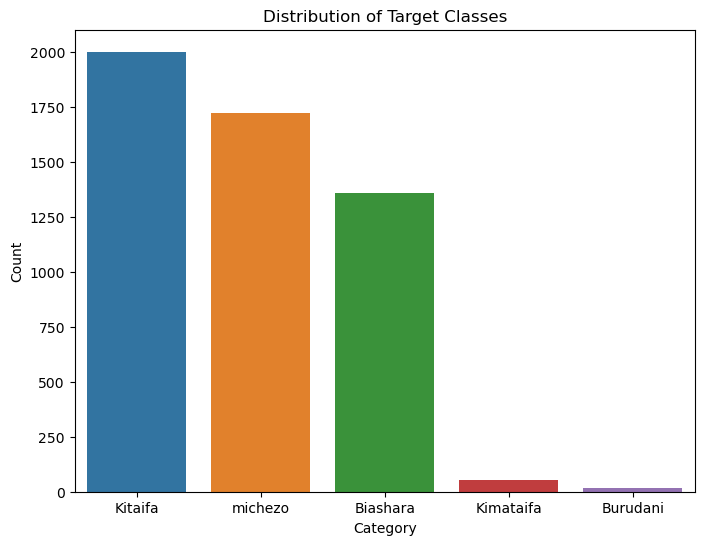

Class Distribution:
Kitaifa      2000
michezo      1720
Biashara     1360
Kimataifa      54
Burudani       17
Name: category, dtype: int64


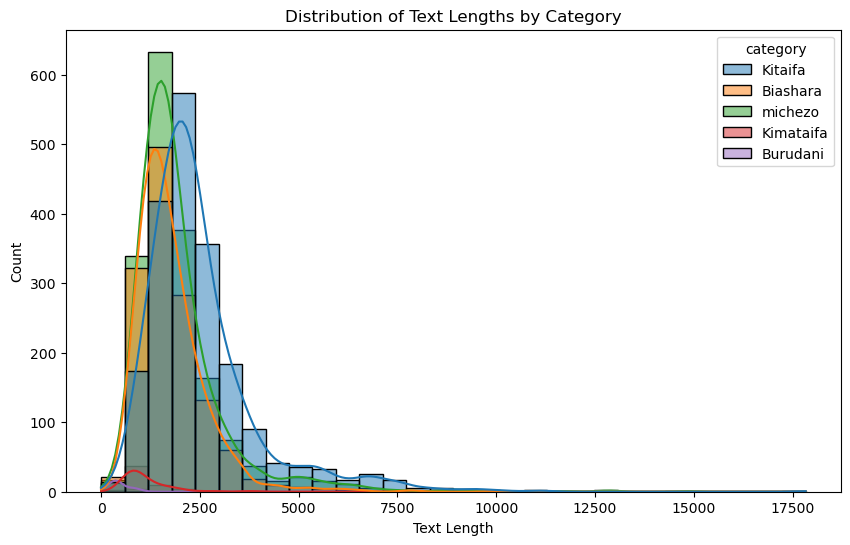


Text Length Statistics by Category:
            count         mean          std    min      25%     50%      75%  \
category                                                                       
Biashara   1360.0  1762.105882   921.760911    1.0  1187.75  1561.0  2119.50   
Burudani     17.0   444.000000   253.111635    1.0   261.00   418.0   474.00   
Kimataifa    54.0  1103.518519   588.134426  550.0   734.50   900.0  1299.00   
Kitaifa    2000.0  2515.078500  1450.370808  302.0  1654.00  2175.0  2880.00   
michezo    1720.0  1953.726163  1239.359351    5.0  1271.75  1664.0  2209.25   

               max  
category            
Biashara   10799.0  
Burudani     992.0  
Kimataifa   3771.0  
Kitaifa    17828.0  
michezo    14829.0  


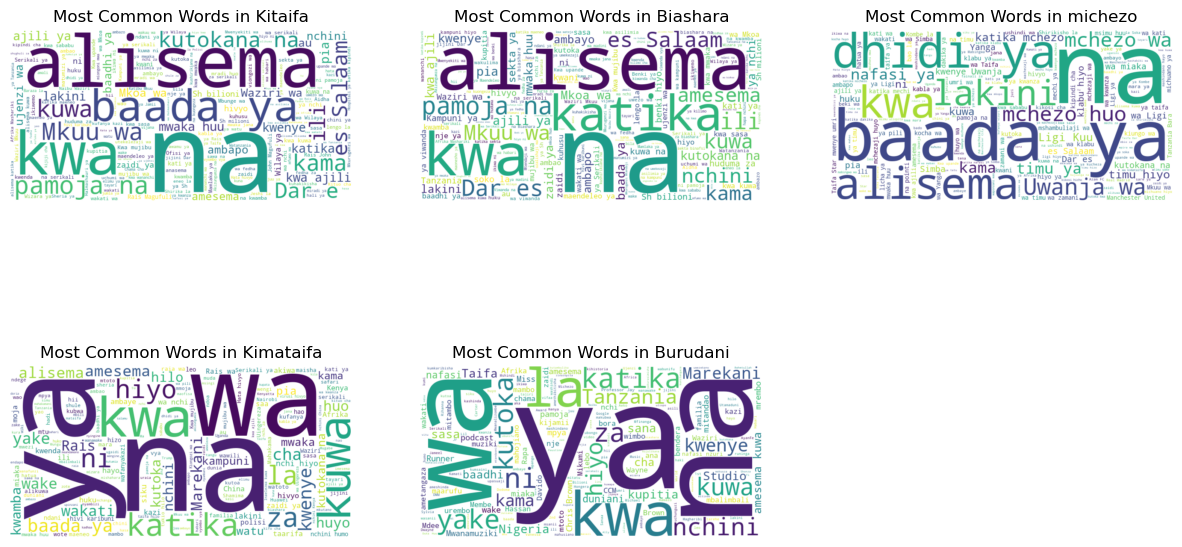

In [27]:

# Display the first few rows of the dataset
print(train_data.head())

# Check for missing values
print(train_data.isnull().sum())


# Check the distribution of target classes
plt.figure(figsize=(8, 6))
sns.countplot(x='category', data=train_data, order=train_data['category'].value_counts().index)
plt.title('Distribution of Target Classes')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# Summary statistics for target classes
class_counts = train_data['category'].value_counts()
print("Class Distribution:")
print(class_counts)


# Explore the distribution of text lengths
train_data['text_length'] = train_data['content'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_data, x='text_length', hue='category', bins=30, kde=True)
plt.title('Distribution of Text Lengths by Category')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

# Summary statistics for text lengths
text_length_stats = train_data.groupby('category')['text_length'].describe()
print("\nText Length Statistics by Category:")
print(text_length_stats)

# Explore the most common words in each category
from wordcloud import WordCloud

categories = train_data['category'].unique()
plt.figure(figsize=(15, 8))
for i, category in enumerate(categories, 1):
    plt.subplot(2, 3, i)
    subset = train_data[train_data['category'] == category]
    wordcloud = WordCloud(width=800, height=400, random_state=42, background_color='white').generate(' '.join(subset['content']))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Common Words in {category}')
    plt.axis('off')
plt.show()

### Class Distribution:

- The class distribution reveals a significant imbalance among the classes. The majority of the samples belong to the "Kitaifa" and "Michezo" categories, while "Kimataifa" and "Burudani" have considerably fewer samples.
- Imbalanced classes may impact the model's ability to generalize well, especially for minority classes.

#### Text Length Statistics by Category:

##### Biashara:
- Mean text length: 1762.11 characters.
- Standard deviation: 921.76 characters.
- The majority of text lengths fall between 1187.75 and 2119.50 characters.
- The longest article has 10799 characters.

##### Burudani:
- Mean text length: 444.00 characters.
- Standard deviation: 253.11 characters.
- Most articles are between 261.00 and 474.00 characters long.
- The longest article has 992 characters.

##### Kimataifa:
- Mean text length: 1103.52 characters.
- Standard deviation: 588.13 characters.
- Text lengths vary, with the majority falling between 734.50 and 1299.00 characters.
- The longest article has 3771 characters.

##### Kitaifa:
- Mean text length: 2515.08 characters.
- Standard deviation: 1450.37 characters.
- The majority of text lengths fall between 1654.00 and 2880.00 characters.
- The longest article has 17828 characters.

##### Michezo:
- Mean text length: 1953.73 characters.
- Standard deviation: 1239.36 characters.
- Most articles are between 1271.75 and 2209.25 characters long.
- The longest article has 14829 characters.

#### Interpretation:

- The text length statistics provide insights into the distribution of article lengths within each category.
- "Kitaifa" articles tend to be longer on average compared to other categories, with a wide range of text lengths.
- "Burudani" articles are relatively shorter on average, with a smaller standard deviation, indicating less variability in text lengths.
- Understanding these patterns can help you tailor your preprocessing steps or choose appropriate text representation techniques for your modeling.

#### Solutions
###### 1. Class Imbalance:
  - a. Class Weighting:
    For the Naive Bayes model, iam going to use the class_prior='balanced' parameter to automatically adjust weights based on the inverse of class frequencies.
   
##### 2. Varying Text Lengths:
  - a. Text Length Normalization:
    I am going to Normalize text lengths by truncating or padding sequences to a consistent length. This ensures that the model processes inputs of the same length.
    I will Set a maximum length based on the analysis of text length statistics.

In [30]:
# Split the data into features (X) and target (y)
X = train_data['content']
y = train_data['category']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a TF-IDF vectorizer and transform the text data using Swahili stop words
swahili_stop_words = ["akasema", "alikuwa", "alisema", "baada", "basi", "bila", "cha", "chini", "hadi", "hapo",
                      "hata", "hivyo", "hiyo", "huku", "huo", "ili", "ilikuwa", "juu", "kama", "karibu", "katika",
                      "kila", "kima", "kisha", "kubwa", "kutoka", "kuwa", "kwa", "kwamba", "kwenda", "kwenye", "la",
                      "lakini", "mara", "mdogo", "mimi", "mkubwa", "mmoja", "moja", "muda", "mwenye", "na", "naye",
                      "ndani", "ng", "ni", "nini", "nonkungu", "pamoja", "pia", "sana", "sasa", "sauti", "tafadhali",
                      "tena", "tu", "vile", "wa", "wakati", "wake", "walikuwa", "wao", "watu", "wengine", "wote", "ya",
                      "yake", "yangu", "yao", "yeye", "yule", "za", "zaidi", "zake"]

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=swahili_stop_words, lowercase=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)  # Fit on training data
X_val_tfidf = tfidf_vectorizer.transform(X_val)  # Transform validation data

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_tfidf_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Build a Multinomial Naive Bayes model
model = MultinomialNB()

# Define the parameter grid for grid search
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

# Create a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Create GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, scoring='neg_log_loss', cv=5)
grid_search.fit(X_train_tfidf_resampled, y_train_resampled)

# Get the best hyperparameters from grid search
best_alpha = grid_search.best_params_['alpha']

# Train the model with the best hyperparameter using cross-validation
model = MultinomialNB(alpha=best_alpha)
cross_val_scores = cross_val_score(model, X_train_tfidf_resampled, y_train_resampled, cv=5, scoring='neg_log_loss')

# Evaluate the model on the validation set before fine-tuning
model.fit(X_train_tfidf_resampled, y_train_resampled)
val_predictions_proba = model.predict_proba(X_val_tfidf)
logloss = log_loss(pd.get_dummies(y_val), val_predictions_proba)

# Additional evaluation metrics before fine-tuning
val_predictions = model.predict(X_val_tfidf)
accuracy = accuracy_score(y_val, val_predictions)
precision = precision_score(y_val, val_predictions, average='weighted')
recall = recall_score(y_val, val_predictions, average='weighted')
f1 = f1_score(y_val, val_predictions, average='weighted')
conf_matrix = confusion_matrix(y_val, val_predictions)

# Print evaluation metrics before fine-tuning
print("Before Fine-Tuning:")
print(f"Validation Log Loss: {logloss}")
print(f"Validation Accuracy: {accuracy}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)



# Load the test data
test_data = pd.read_csv("C:\\Users\\NdoMuteweri\\Desktop\\Machine Learning\\projects\\Swahili News Classification\\Test.csv")

# Preprocess the test data
X_test_tfidf = tfidf_vectorizer.transform(test_data['content'])

# Make predictions on the test data
test_predictions_proba = model.predict_proba(X_test_tfidf)

# Prepare the submission file
submission_df = pd.DataFrame(test_predictions_proba, columns=model.classes_)
submission_df.insert(0, 'swahili_id', test_data['swahili_id'])  # Change 'ID' to 'swahili_id'

# Save the submission file
submission_df.to_csv("submission.csv", index=False)


C:\Users\NdoMuteweri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Before Fine-Tuning:
Validation Log Loss: 0.4669578292928001
Validation Accuracy: 0.8486905916585838
Validation Precision: 0.8473169278199706
Validation Recall: 0.8486905916585838
Validation F1 Score: 0.8456918083780511
Confusion Matrix:
[[246   0   0  26   0]
 [  0   0   1   0   1]
 [  0   0   0   7   2]
 [ 76   0   1 296  11]
 [  3   0   0  28 333]]


Validation Log Loss: The log loss is a measure of how well the predicted probabilities match the true class labels. A lower log loss indicates better performance. In your case, a log loss of 0.4435 is reasonable and suggests that the model's predicted probabilities align well with the actual classes.

Validation Accuracy: Accuracy is the ratio of correctly predicted instances to the total instances. In this case, the model has an accuracy of approximately 85.16%, which means it correctly predicted the category for about 85.16% of the validation set.

Validation Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. It provides insights into the model's ability to avoid false positives. A precision of 0.846 indicates that when the model predicts a certain category, it is correct about 84.6% of the time.

Validation Recall: Recall, also known as sensitivity or true positive rate, is the ratio of correctly predicted positive observations to the total actual positives. It gives an indication of how well the model captures all instances of a particular category. A recall of 0.852 suggests that the model identified about 85.2% of the actual instances of the positive class.

Validation F1 Score: The F1 score is the harmonic mean of precision and recall, providing a balance between the two metrics. An F1 score of 0.848 indicates a good balance between precision and recall.

Confusion Matrix: The confusion matrix provides a detailed breakdown of the model's predictions. Rows represent the actual classes, and columns represent the predicted classes. Each entry (i, j) in the matrix denotes the number of instances of class i that were predicted as class j. For example:

Class 0 (Kitaifa): 228 instances correctly predicted, 44 instances predicted as class 3 (Michezo), and no instances predicted as other classes.
Class 1 (Kimataifa): No instances correctly predicted, 1 instance predicted as class 3 (Michezo), and 1 instance predicted as class 4 (Burudani).
Class 2 (Biashara): No instances correctly predicted, 7 instances predicted as class 3 (Michezo), and 2 instances predicted as class 4 (Burudani).
Class 3 (Michezo): 318 instances correctly predicted, 55 instances predicted as class 0 (Kitaifa), and 11 instances predicted as class 4 (Burudani).
Class 4 (Burudani): 332 instances correctly predicted, 3 instances predicted as class 0 (Kitaifa), and 29 instances predicted as class 3 (Michezo).